## CASPER: Context-Aware Anomaly Detection System for Industrial Robotic Arms

GitHub Repository: https://github.com/hkayann/1D-CNN-Anomaly-Detection-via-CASPER

This notebook explains all the evaluation process of the paper titled as: **CASPER: Context-Aware IoT Anomaly Detection System for Industrial Robotic Arms**

The links for the dataset:

* Download the dataset from the [Kaggle](https://www.kaggle.com/datasets/hkayan/industrial-robotic-arm-anomaly-detection).
* (Alternative) Download the dataset from [IEEEPort](https://ieee-dataport.org/documents/casper-context-aware-anomaly-detection-system-industrial-robotic-arms).

Other files including models/results are given in GitHub repository.

The file paths are subject to change per user/platform. Please **double-check the paths** to avoid errors.

The sections that have `%%time` are the ones that take relatively longer to process.

Repetitive code is present to run the methods **standalone**.

If kernel dies during the experiment, run **until the warning**. Then, you can move into method you desire.

For any enquiries, please e-mail me `(kayanh@cardiff.ac.uk)` or open a GitHub issue.

The docker does not contain the following libraries, so we **manually install** them. Please uncomment below cell to install them, then you can comment again.

In [56]:
# !pip install ahrs
# !pip install scikit-learn
# !pip install seaborn
# !pip install pandas
# !pip install xgboost
# !pip install pyyaml h5py

In [57]:
# Import required libraries.
import ahrs
import IPython
import IPython.display
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb

from ahrs.filters import Madgwick, Mahony
from IPython.utils import io
from pprint import pprint
from scipy import signal
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars, SGDRegressor
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import OneClassSVM
from tensorflow.keras import regularizers

# Surpress unnecessary warning.
pd.options.mode.chained_assignment = None  # default='warn'
mpl.rcParams.update(mpl.rcParamsDefault) # Fixes a bug.

We check if we have an access to Nvidia GPU. If you are not running this on Nvidia, skip the below cell.

In [58]:
# Check for TensorFlow GPU access.
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version.
print(f"TensorFlow version: {tf.__version__}")

# If you are on ARM-based MacOS this will return "command not found".
# In that case, you need to consider the output of above statements. 
!nvidia-smi -L
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# This is useful on Google Colab to check if high-RAM is selected.
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.11.0
GPU 0: NVIDIA RTX A6000 (UUID: GPU-76748847-01f8-4453-46b2-72ba4a516e70)
Tue Apr  4 19:00:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:65:00.0 Off |                  Off |
| 30%   31C    P8    16W / 300W |  47799MiB / 4

## Dataset Matching

We have **2 data sources** that we need to match:
1. Built-in parameters data that contain the anomaly labels.
2. Nicla Sense ME data where we apply the anomaly detection algorithms.

We should correctly match the anomalous labels we got from the 1st data to 2nd.

#### The reasons for the mismatch in data sources:
1. Even thought we set both freqs to 20Hz with the given available libraries, we see that the freqs differ around **18Hz to 22Hz**.
2. The Nicla stopped **after the industrial robotic arm** (estimatedly few minutes.)
3. The Nicla **started earlier** than the industrial robotic arm.

If the freq was exactly **20Hz**, we would had **1728000** data points after 24 hours.

Now we match the data sources based on the **location of the first anomalous point**.

In [59]:
# Generate Nicla dataframe, perform initial checks.
# If local the path:
nicla_path = "./datasets/nicla.csv"

# We skip first 6 rows due to faulty format/data.
nicla = pd.read_csv(nicla_path, on_bad_lines='warn', skiprows=6, 
                    names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"])

# Check if there are any empty/Nan variables. 
if nicla.isnull().values.any():
    raise ValueError("Nan variable is present.")

# Explore the dataframe.
print(nicla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751682 entries, 0 to 1751681
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyroX   float64
 4   GyroY   float64
 5   GyroZ   float64
 6   MagX    float64
 7   MagY    float64
 8   MagZ    float64
dtypes: float64(9)
memory usage: 120.3 MB
None


We visualize **first 1000 points** to understand **when movement starts.**. We know the following:
 * The arm data are generated as soon as arm starts moving.
 * The Nicla starts generating data before the arm (few seconds).

 Thus, the initial Nicla data are **IDLE**, which we remove now.

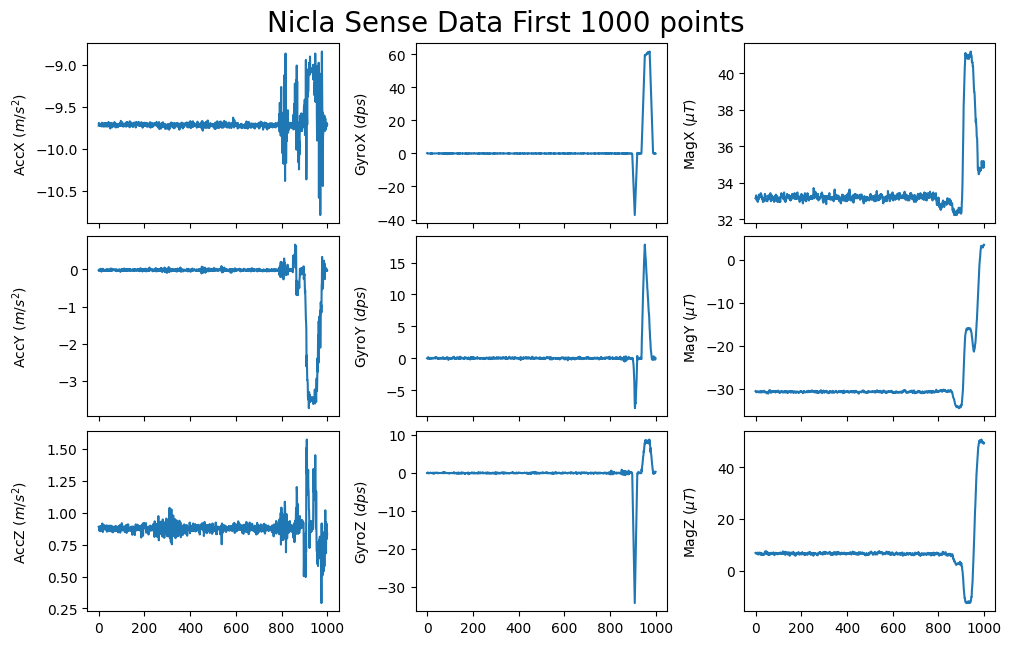

In [60]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

start_index = 0
end_index = 1000

ax1.plot(nicla.index[start_index:end_index], nicla['AccX'][start_index:end_index])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(nicla.index[start_index:end_index], nicla['GyroX'][start_index:end_index])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(nicla.index[start_index:end_index], nicla['MagX'][start_index:end_index])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(nicla.index[start_index:end_index], nicla['AccY'][start_index:end_index])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(nicla.index[start_index:end_index], nicla['GyroY'][start_index:end_index])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(nicla.index[start_index:end_index], nicla['MagY'][start_index:end_index])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(nicla.index[start_index:end_index], nicla['AccZ'][start_index:end_index])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(nicla.index[start_index:end_index], nicla['GyroZ'][start_index:end_index])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(nicla.index[start_index:end_index], nicla['MagZ'][start_index:end_index])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
plt.suptitle("Nicla Sense Data First 1000 points", x = 0.5, y = 1.05, fontsize = 20)
plt.show()

We see that the Nicla is idle for some time. We now find the **exact starting point**.

In [61]:
# We see that Gyro. noise occurs at range of 0 < x < 1, so we find the first point where x >= 1
index = np.argmax(nicla['GyroX'][:1000].diff().abs() >= 1)
index

898

As the movement starts at (roughly) 898th data point we can **remove the first 897 data points.**

In [62]:
# Drop the first 898 points.
nicla_dropped = nicla.iloc[897:]
# Reset the index.
nicla_dropped.index = pd.RangeIndex(len(nicla_dropped.index))

Now, we load the **built-in arm dataset.**

In [63]:
%%time
# Generate df from dataset that contains labels/built-in parameters.
# Path for local PC.
right_arm_csv_path = "./datasets/right_arm.csv"

# Generate the dataframe.
right_arm = pd.read_csv(right_arm_csv_path, on_bad_lines='warn')

# Reset Timestamp to 0.
right_arm["Timestamp"] = right_arm["Timestamp"] - right_arm["Timestamp"][0]

CPU times: user 15.9 s, sys: 1.12 s, total: 17 s
Wall time: 17 s


In [9]:
# Get the lengths of nicla and arm data.
len_nicla_dropped = len(nicla_dropped)
len_right_arm = len(right_arm)

print(f"The length of the right arm data is {len_right_arm}")
print(f"The length of the nicla data is {len_nicla_dropped}")

The length of the right arm data is 1762650
The length of the nicla data is 1750785


As we see the lengths **do not match**. The **final point** of built-in dataset is an **anomaly**, that is how we can locate the **exact end of the 24 hour period.**

Now, we find the final **1** which corresponds to an anomaly.

In [10]:
# Find the final 1.
df_labels = right_arm["Anomaly State"]
index_list = np.where(df_labels == 1)
index_of_last_one = index_list[0][-1]
print(f"The final 1 is located at: {index_of_last_one}")

The final 1 is located at: 1728006


We run the test for just a bit more than 24 hours, while setting operation to normal after 24 hours.

The final 1 is at 1728006, well, this makes sense, because the **24 hour data at 20Hz means 1728000 data points**. We only have **6 extra** data points in this case.

We now **match the datasets**.

Now we try to find corresponding points at Nicla.

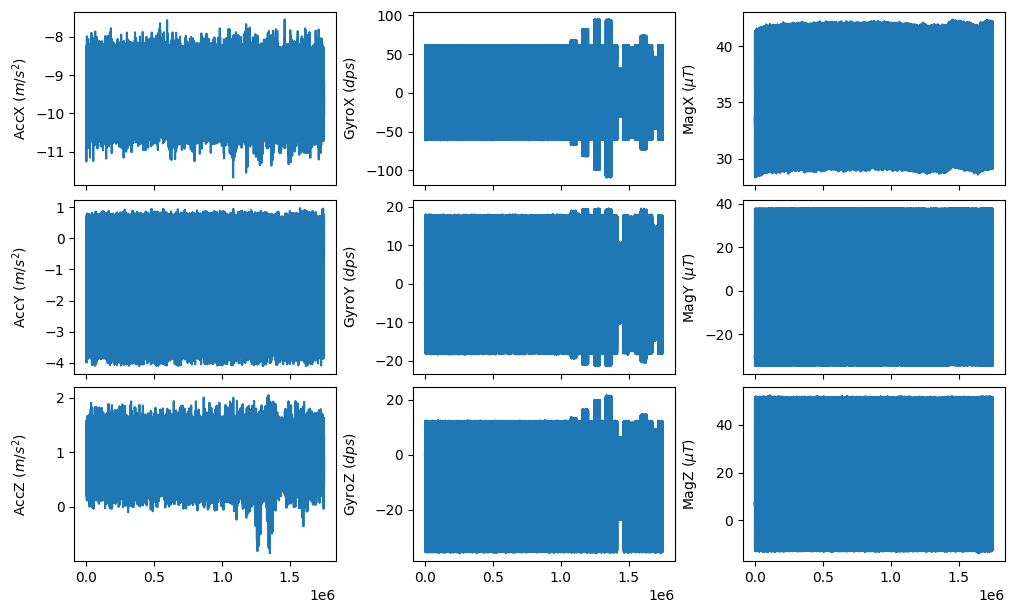

In [11]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex = True, figsize=(10, 6), constrained_layout=True)

ax1.plot(nicla.index, nicla['AccX'])
ax1.set_ylabel(r'AccX $(m/s^2)$')

ax2.plot(nicla.index, nicla['GyroX'])
ax2.set_ylabel(r'GyroX $(dps)$')

ax3.plot(nicla.index, nicla['MagX'])
ax3.set_ylabel(r'MagX (${\mu}T$)')

ax4.plot(nicla.index, nicla['AccY'])
ax4.set_ylabel(r'AccY $(m/s^2)$')

ax5.plot(nicla.index, nicla['GyroY'])
ax5.set_ylabel(r'GyroY $(dps)$')

ax6.plot(nicla.index, nicla['MagY'])
ax6.set_ylabel(r'MagY (${\mu}T$)')

ax7.plot(nicla.index, nicla['AccZ'])
ax7.set_ylabel(r'AccZ $(m/s^2)$')

ax8.plot(nicla.index, nicla['GyroZ'])
ax8.set_ylabel(r'GyroZ $(dps)$')

ax9.plot(nicla.index, nicla['MagZ'])
ax9.set_ylabel(r'MagZ (${\mu}T$)')

fig.align_labels()
fig.savefig("figures/niclaData.pdf", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The anomalies are most obvious on **GyroX**, thus we utilize that feature for matching the datasets. 

We also compare the anomaly points seen in **arm** and the anomaly points seen in **Nicla**.

In [12]:
# Remove the rest of the data.
right_arm = right_arm[0:1728000]
# Check the anomaly labels.
df_anol = right_arm["Anomaly State"]
# Find the first anomaly point.
idx_f = (df_anol == 1.0).idxmax()

# Get the GyroX feature.
df_gyroX = nicla_dropped["GyroX"]
# Convert into numpy array.
gyroX = df_gyroX.to_numpy()
# Get first 1 m data points that we know its normal.
gyroX_1m = gyroX[0:1000000]
gyroX_1m_min = np.min(gyroX_1m)
gyroX_1m_max = np.max(gyroX_1m)

# Find the data either bigger than max or lower then min.
greater_indices = np.argwhere(gyroX > gyroX_1m_max)
lesser_indices = np.argwhere(gyroX < gyroX_1m_min)

first_greater = greater_indices[0][0]
first_lesser = lesser_indices[0][0]
last_greater = greater_indices[-1][0]
last_lesser = lesser_indices[-1][0]

print(f"The first greater than max at {first_greater}, the first lesser than min at {first_lesser}.")
print(f"The first anomaly point in Arm data seen at {idx_f}.")
print(f"The final anomaly point in Arm data seen at {index_of_last_one}.")
print(f"The final anomaly point in Nicla-Gyro data seen at {last_lesser}.")

The first greater than max at 1072794, the first lesser than min at 1072917.
The first anomaly point in Arm data seen at 1080004.
The final anomaly point in Arm data seen at 1728006.
The final anomaly point in Nicla-Gyro data seen at 1629872.


We start anomalies **after 15 hours** (corresponds to data point at 1080000). 

However, when we manually try to label the Nicla data based on min-max thresholding the GyroX feature, anomalies seems to start at 1072794.

Thus, we need to analyze further.

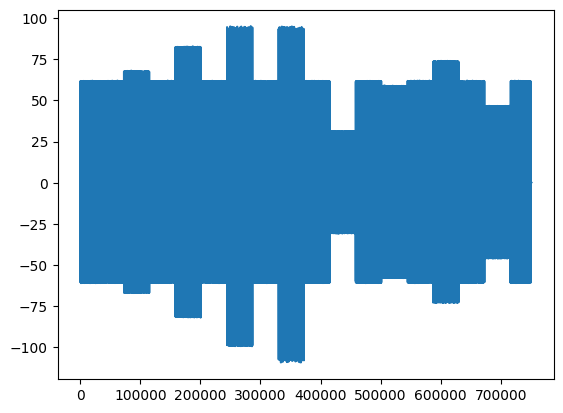

In [13]:
# Remove the first 1m points as we know they are normal.
gyroX_a_1m = gyroX[1000000:]
plt.plot(gyroX_a_1m)
plt.show()

Before matching labels, we need to filter the noise as the **data length will change**.

We apply **moving median filter** with fixed window size.

We know that the final point after 24 hours of test is an anomaly, so we **get rid of the rest**.

In [14]:
# First we need to filter the noise.
# Remove the rest (after the final anomaly point).
nicla_fixed = nicla_dropped[:1716474+1]

# Set window size for moving median.
f_window_size = 20

# Apply moving median and convert back to numpy array for faster ops.
nicla_filtered= nicla_fixed.rolling(f_window_size).median().dropna().to_numpy()

Now that we get rid of the noise, we spot where exactly anomaly run starts via **visually analyzing the data.**

In [15]:
len(nicla_filtered)

1716456

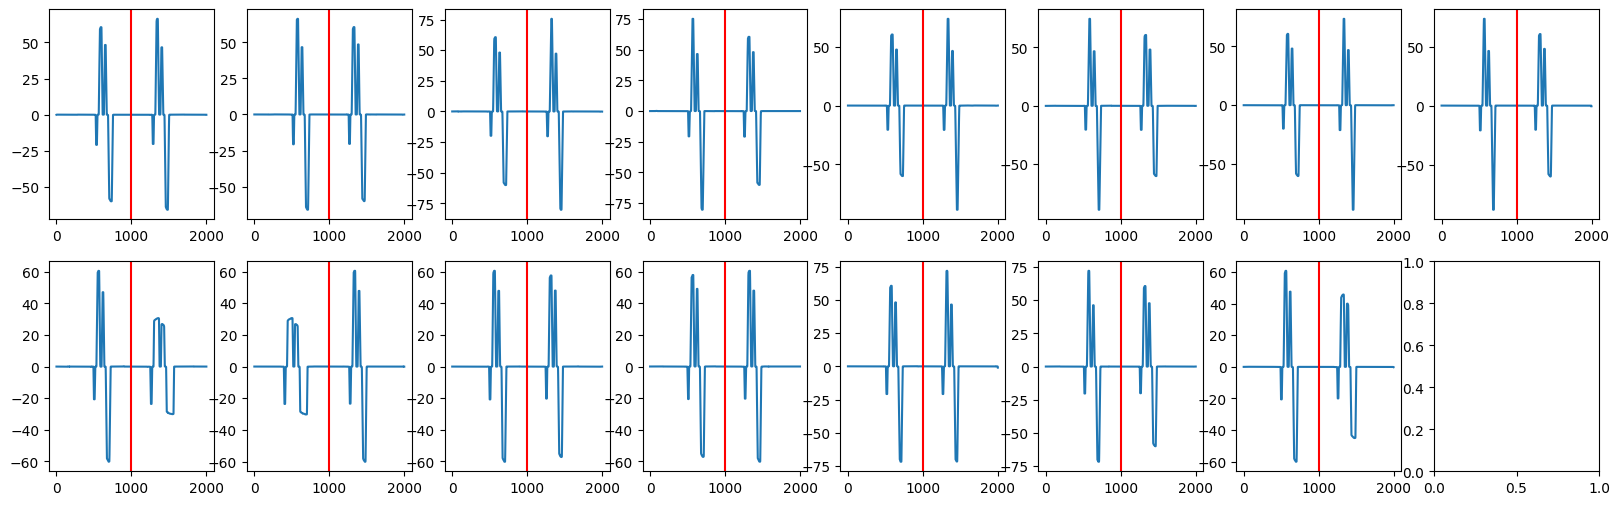

In [16]:
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8), 
      (ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)) = plt.subplots(nrows=2, ncols=8, figsize=(20, 6))
# First jump seen at around 1072450.
ax1.plot(nicla_filtered[1071450:1073450, 3])
ax1.axvline(x=1000, color='red')
# First down seen at around 1115125.
ax2.plot(nicla_filtered[1114125:1116125, 3])
ax2.axvline(x=1000, color='red')
# Second jump seen at around 1158150.
ax3.plot(nicla_filtered[1157150:1159150, 3])
ax3.axvline(x=1000, color='red')
# Second down seen at around 1201100.
ax4.plot(nicla_filtered[1200100:1202100, 3])
ax4.axvline(x=1000, color='red')
# Third up seen at around 1244100.
ax5.plot(nicla_filtered[1243100:1245100, 3])
ax5.axvline(x=1000, color='red')
# Third down seen at around 1286875.
ax6.plot(nicla_filtered[1285875:1287875, 3])
ax6.axvline(x=1000, color='red')
# Fourth up seen at around 1329900.
ax7.plot(nicla_filtered[1328900:1330900, 3])
ax7.axvline(x=1000, color='red')
# Fourth down seen at around 1372650.
ax8.plot(nicla_filtered[1371675:1373675, 3])
ax8.axvline(x=1000, color='red')
# Fifth down seen at around 1415700.
ax9.plot(nicla_filtered[1414700:1416700, 3])
ax9.axvline(x=1000, color='red')
# Fifth up seen at around 1458415.
ax10.plot(nicla_filtered[1457415:1459415, 3])
ax10.axvline(x=1000, color='red')
# Sixth down seen at around 1501500.
ax11.plot(nicla_filtered[1500475:1502475, 3])
ax11.axvline(x=1000, color='red')
# Sixth up seen at around 1544725.
ax12.plot(nicla_filtered[1543725:1545725, 3])
ax12.axvline(x=1000, color='red')
# Seventh up seen at around 1587750.
ax13.plot(nicla_filtered[1586750:1588750, 3])
ax13.axvline(x=1000, color='red')
# Seventh down seen at around 1630150.
ax14.plot(nicla_filtered[1629150:1631150, 3])
ax14.axvline(x=1000, color='red')
# Eighth down seen at around 1673200.
ax15.plot(nicla_filtered[1672200:1674200, 3])
ax15.axvline(x=1000, color='red')
# Then rest of the data is an anomaly.
plt.show()

We **manually** detect (error rate is < 1%) starting and ending points of anomaly event manually from the above graphs.
The anomalies are seen at below intervals (after 1m points):
1. **10% increase** at joint velocity between **72450 - 115125**.
1. **35% increase** at joint velocity between **158150 - 201100**.
1. **65% increase** at joint velocity between **244100 - 286875**.
1. **100% increase** at joint velocity between **329900 - 372650**.
1. **50% decrease** at joint velocity between **415700 - 458415**.
1. **5% decrease** at joint velocity between **501500 - 544725**.
1. **20% increase** at joint velocity between **587750 - 630150**.
1. **25% decrease** at joint velocity between **673200 - 716456 (the final point)**.

We see that first anomaly is seen at 1072450 while the expected point is 1080000 if the data rate would be 20Hz.

1072450 corresponds to a data rate at 19.86Hz which explains the difference. The last point being at 1716456 also confirms this.

While one solution would be shifting the data based on this information, for the sake of accuracy we manually label the data.

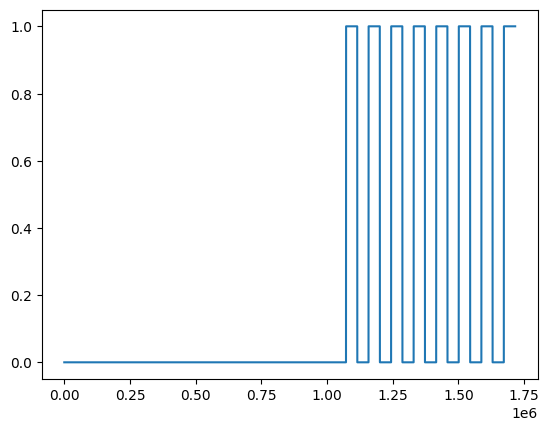

In [17]:
# Create a numpy array that will hold anomaly labels. 
len_nicla = len(nicla_filtered)
np_labels = np.zeros((len_nicla, 1))
# Set anomaly points to ones.
np_labels[1072450:1115125] = 1
np_labels[1158150:1201100] = 1
np_labels[1244100:1286875] = 1
np_labels[1329900:1372650] = 1
np_labels[1415700:1458415] = 1
np_labels[1501500:1544725] = 1
np_labels[1587750:1630150] = 1
np_labels[1673200:1716456] = 1
# Plot the labels for a visual check.
plt.plot(np_labels)
plt.show()

Now we will move onto feature preprocessing part where we gain more insight regarding the input data.

## Feature Preprocessing - Nicla Data

In this work, we would like to come up with a solution that is scalable to any industrial arm that is doing any kind of movement.

Thus, even though, for this work, analysis of GyroX feature is adequate, we go for solutions that considers all the input features.

We split the data into two:
   1. Data with **normal runs**.
   2. Data with **anomalous runs**.

In [18]:
# Split the non-anomalous and anomalous data.
nicla_nor = nicla_filtered[:1072450]
nicla_anol = nicla_filtered[1072450:]
# We only need labels for after 1st anomalous point
# as it will be our test data.
np_labels_test = np_labels[1072450:]

In [19]:
# Split the features to single arrays.
np_accX = nicla_nor[:, 0]
np_accY = nicla_nor[:, 1]
np_accZ = nicla_nor[:, 2]
np_gyroX = nicla_nor[:, 3]
np_gyroY = nicla_nor[:, 4]
np_gyroZ = nicla_nor[:, 5]
np_magX = nicla_nor[:, 6]
np_magY = nicla_nor[:, 7]
np_magZ = nicla_nor[:, 8]

# Combine the features per modality.
np_acc = np.stack([np_accX, np_accY, np_accZ], axis=1)
np_gyro = np.stack([np_gyroX, np_gyroY, np_gyroZ], axis=1)
np_mag = np.stack([np_magX, np_magY, np_magZ], axis=1)

### If kernel dies, feel free to run until here. Then you can jump to a point where you left.

### Correlation Analysis

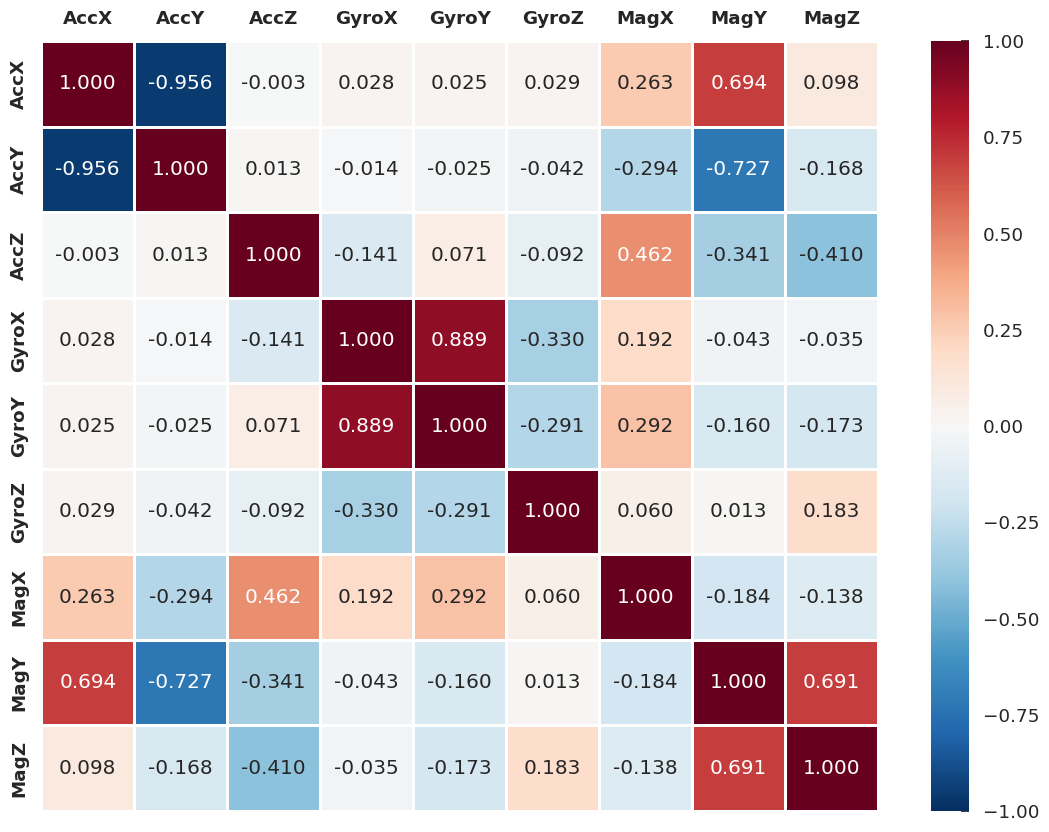

In [20]:
def cal_corr(arr):
    """
    Calculates the pearson correlation coefficient of given numpy arrays.
    Args:
        arr (list): A list containing numpy arrays.
    Returns:
        numpy_ndarray: A matrix that contains correlation coefficients.
    """
    corr_matrix = np.corrcoef(arr)
    return corr_matrix

# Set tick labels.
tick_labels = ["AccX", "AccY", "AccZ",
               "GyroX", "GyroY", "GyroZ",
               "MagX", "MagY", "MagZ"]
# Check how input features correlate with each other.
corr_mat = cal_corr([np_accX, np_accY, np_accZ, 
                     np_gyroX, np_gyroY, np_gyroZ, 
                     np_magX, np_magY, np_magZ])

plt.figure(figsize=(13.5, 10))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mat, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=True, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=tick_labels, yticklabels=tick_labels)

# Get the colorbar object.
cbar = ax.collections[0].colorbar
# Set the location of the colorbar ticks to the right.
cbar.ax.yaxis.set_tick_params(pad=10, direction='in', labelright=True, labelleft=False)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('figures/corr_heatmap_IMU.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Based on the above matrix, the highest correlated features in order are:
1. AccX and AccY with pcc = **-0.956** 
2. GyroX and GyroY with pcc = **0.889**
3. AccY and MagY with pcc = **-0.727**  

When pcc > 0.7 or pcc < -0.7, we accept that as a strong correlation. In this case, features of GyroX and GyroY, AccY and MagY seems to highly correlate.

Even though, the **single features might not correlate**, sets of features can. Now we check if accelerometer, gyroscrope and magnetometer data correlate with each other.

To find how sets of features correlate we apply **canonical-correlation analysis (CCA)**.

In [21]:
# Standardize with zero mean and unit variance / only normal data.
scaler = StandardScaler() 
acc_sc = scaler.fit_transform(np_acc)
gyro_sc = scaler.fit_transform(np_gyro) 
mag_sc = scaler.fit_transform(np_mag) 

# Apply CCA. 
n_comp = 3
cca_1 = CCA(scale=False, n_components=n_comp)
cca_2 = CCA(scale=False, n_components=n_comp)
cca_3 = CCA(scale=False, n_components=n_comp)
cca_1.fit(acc_sc, gyro_sc)
cca_2.fit(acc_sc, mag_sc)
cca_3.fit(gyro_sc, mag_sc)
acc_c_1, gyro_c_1 = cca_1.transform(acc_sc, gyro_sc)
acc_c_2, mag_c_1 = cca_2.transform(acc_sc, mag_sc)
gyro_c_2, mag_c_2 = cca_3.transform(gyro_sc, mag_sc)

# Canonical variate correlations.
acc_gyro_corr = [np.corrcoef(acc_c_1[:, i], gyro_c_1[:, i])[1][0] for i in range(n_comp)]
acc_mag_corr = [np.corrcoef(acc_c_2[:, i], mag_c_1[:, i])[1][0] for i in range(n_comp)]
gyro_mag_corr = [np.corrcoef(gyro_c_2[:, i], mag_c_2[:, i])[1][0] for i in range(n_comp)]

print(f"Acc-Gyro cvc: {acc_gyro_corr}")
print(f"Acc-Mag cvc: {acc_mag_corr}")
print(f"Gyro-Mag cvc: {gyro_mag_corr}")

Acc-Gyro cvc: [0.4856142661636787, 0.07371715418811822, 0.028344309945593636]
Acc-Mag cvc: [0.9696214582282641, 0.5802248892976098, 0.27068518080662735]
Gyro-Mag cvc: [0.41173840407552265, 0.3043020156228818, 0.07603021337917881]


This confirms our previous per feature correlation analysis.

In this case, the **accelerometer and magnetometer** data highly correlate.

### Feature Fusion Techniques

We utilize **Madgwick and Mahony filters** to generate quaternions to define orientation.

In [22]:
%%time
# We know our data at roughly 19.86Hz.
s_period = 1 / 19.86
mad_fil = Madgwick(sample_period=s_period)
mah_fil = Mahony(sample_period=s_period)
# Set the identity quaternion, so we accept as zero rotation.
q = np.empty((len(np_acc), 4))
q_mahony = np.empty((len(np_acc), 4))
q[0] = np.array([1.0, 0.0, 0.0, 0.0])
q_mahony[0] = np.array([1.0, 0.0, 0.0, 0.0])
# Calculate quaternions.
for i in range(1, len(np_acc)):
    q[i] = mad_fil.updateMARG(q[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])
    q_mahony[i] = mah_fil.updateMARG(q_mahony[i-1], acc=np_acc[i-1], gyr=np_gyro[i-1], mag=np_mag[i-1])

CPU times: user 2min 5s, sys: 11.8 ms, total: 2min 5s
Wall time: 2min 5s


We check how data correlates when quaternions are the input features.

In [23]:
# Split the features to single arrays.
q_0 = q[:, 0]
q_1 = q[:, 1]
q_2 = q[:, 2]
q_3 = q[:, 3]
q_mahony_0 = q_mahony[:, 0]
q_mahony_1 = q_mahony[:, 1]
q_mahony_2 = q_mahony[:, 2]
q_mahony_3 = q_mahony[:, 3]

# Check how input features correlate with each other.
corr_mad = cal_corr([q_0, q_1, q_2, q_3])
corr_mah = cal_corr([q_mahony_0, q_mahony_1, q_mahony_2, q_mahony_3])
print(corr_mad)
print(corr_mah)

[[ 1.          0.01543437 -0.003104    0.31948101]
 [ 0.01543437  1.         -0.2838297  -0.02259608]
 [-0.003104   -0.2838297   1.          0.01661727]
 [ 0.31948101 -0.02259608  0.01661727  1.        ]]
[[ 1.          0.46047982  0.93099665 -0.61002263]
 [ 0.46047982  1.          0.17652929 -0.83840541]
 [ 0.93099665  0.17652929  1.         -0.4621761 ]
 [-0.61002263 -0.83840541 -0.4621761   1.        ]]


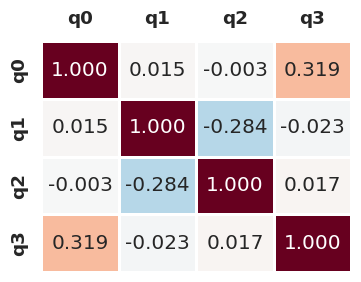

In [24]:
# Visualize the correlation map of Madgwick.
q_tick_labels = ["q0", "q1", "q2", "q3"]
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mad, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('figures/corr_heatmap_madgwick.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

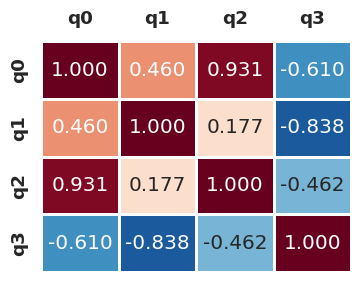

In [25]:
# Visualize the correlation map of Mahony.
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)
ax = sns.heatmap(corr_mah, cmap='RdBu_r', annot=True, linewidths=1, vmin=-1, 
                 square=False, cbar=False, fmt='.3f', annot_kws={"fontweight": "light"},
                 xticklabels=q_tick_labels, yticklabels=q_tick_labels)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
plt.savefig('figures/corr_heatmap_mahony.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

The quaternions of Madgwick do not highly correlate.

The highly correlated quaternion features of **Mahony** filtering are:
1. **q0** and **q2** with pcc = **0.931**
2. **q1** and **q3** with pcc = **-0.838**

The quaternions generated via Mahony seems to correlate more than Madgwick generated ones.

This makes **Madgwick** more suitable for the regression analysis.

## PCA VS PLS

PCA has some drawbacks. It is blind to response (unsupervised). It does not consider the relation between the predictor and response. 

Now we try **PLS** which does not have such a drawback.

In [26]:
%%time
# Set features/parameters.
num_folds = 10
tscv = TimeSeriesSplit(n_splits=num_folds)
window_size = 755
# We only scale the training data as we should not
# have access the future values.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))
n_components = 7

# Set PLS and PCR.
pls = make_pipeline(PLSRegression(n_components=n_components))
pcr = make_pipeline(PCA(n_components=n_components, random_state = 42), LinearRegression())

# Remove the final "window_size" points, as they will be predicted only.
sample = IMU_non_scaled[:-window_size]
# Shift the validation set by window_size
sample2 = IMU_non_scaled[window_size:]

# Set scaler.
scaler_ss = StandardScaler()

# Store the performance metrics for each fold.
rmse_scores_pls, r2_scores_pls = [], []
rmse_scores_pcr, r2_scores_pcr = [], []

# Apply linear regression via cross validation.
for fold, (train_idx, val_idx) in enumerate(tscv.split(sample)):
        
    # Split data for time series cross validation.
    X_train, X_val = sample[train_idx], sample[val_idx]
    y_train, y_val = sample2[train_idx], sample2[val_idx]
    
    # Scale and center the data.
    X_train = scaler_ss.fit_transform(X_train)
    y_train = scaler_ss.fit_transform(y_train)
    X_val = scaler_ss.fit_transform(X_val)
    y_val = scaler_ss.fit_transform(y_val)
    # Fit the PLS, PCR to data.
    pls.fit(X_train, y_train)
    pcr.fit(X_train, y_train)
    # Retrieve the PCA step of the pipeline.
    pca = pcr.named_steps["pca"]
    
    # Predict.
    y_pred_pls = pls.predict(X_val)
    y_pred_pcr = pcr.predict(X_val)
    
    # Calculate RMSE and R2.
    rmse_pls = mean_squared_error(y_val, y_pred_pls, squared=False)
    r2_pls = pls.score(y_pred_pls, y_val)
    rmse_pcr = mean_squared_error(y_val, y_pred_pcr, squared=False)
    r2_pcr = pcr.score(y_pred_pcr, y_val)
    
    # Save the scores.
    rmse_scores_pls.append(rmse_pls) 
    r2_scores_pls.append(r2_pls) 
    rmse_scores_pcr.append(rmse_pcr)
    r2_scores_pcr.append(r2_pcr)

print(f"PLS RMSE = {np.mean(rmse_scores_pls)}, PCR RMSE = {np.mean(rmse_scores_pcr)}")
print(f"PLS R2 = {np.mean(r2_scores_pls)}, PCR R2 = {np.mean(r2_scores_pcr)}")

PLS RMSE = 0.15863883947282467, PCR RMSE = 0.15919576168528443
PLS R2 = 0.957932525479448, PCR R2 = 0.9577945901315823
CPU times: user 1min 56s, sys: 2min 41s, total: 4min 38s
Wall time: 26 s


We see the **PLS can beat PCR** here. However, the results are pretty close.

In our case, **PCA/PLS** can reduce the number of predictors to **7** which explain **99%** of the variation. 
Now we have the following independent (predictors/features) variables available for regression/anomaly detection:

1. IMU independents:
    * 9 features in total, ranging from AccX to MagZ.
    * Some independents **highly correlate** with each other.
    * Zero information loss.
2. Madgwick Quaternions:
    * 4 features in total, ranging from q0 to q3.
    * They **do not correlate** with each other.
    * Some information loss.
3. Mahony Quaternions:
    * 4 features in total, ranging from q0 to q3.
    * They **do correlate** with each other.
    * Some information loss.
4. PCA projected data:
    * 7 features in total.
    * They **do not correlate** with each other.
    * Some information loss.
5. PLS projected data:
    * 7 features in total.
    * They **do not correlate** with each other.
    * Some information loss.

For pure regression (non-anomalous data), PLS would work well, but when the input has anomalies these methods fail. 
Thus for the rest of the work, we utilize **raw IMU only.** As the **Madgwick quaternions** look promising, we consider them using in the **future work**.

## Anomaly Detection
### Linear Regression

First we try to find anomalies via linear regression. First we check **how the anomalous part correlates.**

In [27]:
%%time
# Find autocorrelation example.
def df_autocorr(df, lag=1, axis=0):
    """
    Compute the full-sample column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.
    axis : int, optional (default=0)
        The axis along which to compute the autocorrelation.

    Returns:
    --------
    pandas.Series
        A Series containing the autocorrelation coefficients for each column of the input DataFrame.
    """
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

def df_rolling_autocorr(df, window, lag=1):
    """
    Compute the rolling column-wise autocorrelation for a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window : int
        The size of the rolling window.
    lag : int, optional (default=1)
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the rolling autocorrelation coefficients for each column of the input DataFrame.
    """

    return (df.rolling(window=window)
        .corr(df.shift(lag)))

def df_autocorr_highest(df, window_min, window_max, lag_f):
    """
    Compute the highest mean correlation with respect to window length for each column of a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame.
    window_min : int
        The minimum window size to consider.
    window_max : int
        The maximum window size to consider.
    lag_f : int
        The lag at which to compute the autocorrelation.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the highest mean correlation and corresponding window size for each column of the input DataFrame.
    """
    df_corrs = pd.DataFrame()
    df_corr_dict = {}
    for i in range(len(df.columns)):
        corr_init = 0
        corr_index = 0
        for j in range(window_min, window_max): 
            corr = df_rolling_autocorr(df.iloc[:,i], window=j, lag=lag_f).dropna().mean()
            if corr > corr_init:
                corr_init = corr
                corr_index = j
        corr_label = df.columns[i] + "_corr"    
        df_corrs[corr_label] = [corr_init, corr_index]
        df_corr_dict[corr_label] = [corr_init, corr_index]
    return df_corr_dict

# First we find how anomalous part autocorrelates.
corr = df_autocorr_highest(pd.DataFrame(nicla_anol, columns=tick_labels), 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9957346283953076, 755],
 'AccY_corr': [0.9989053364695906, 753],
 'AccZ_corr': [0.976514706396234, 771],
 'GyroX_corr': [0.9977984671409795, 758],
 'GyroY_corr': [0.9966524746112579, 756],
 'GyroZ_corr': [0.9951850638555725, 751],
 'MagX_corr': [0.9985352621573919, 756],
 'MagY_corr': [0.9996707877734609, 764],
 'MagZ_corr': [0.9991869677688926, 755]}
CPU times: user 2min 3s, sys: 538 ms, total: 2min 3s
Wall time: 2min 3s


We see that due to the anomalies, this data **do not correlate** like non-anomalous data.

Let's see if **anomaly detection works with linear regression**.

In [28]:
n = len(nicla_anol)

# Predict the anomalous data via last n (equals to length of anomalous data) points of normal.
y_pred_anol = pls.predict(IMU_non_scaled[-n:])

# Calculate residuals.
res_pls = np.abs(nicla_anol - y_pred_anol)

# Sum all the residuals.
res_sum = np.sum(res_pls, axis=1)

# Set example threshold.
th = np.median(res_sum)

# Array for holding prediction labels.
arr_pred = np.zeros(len(res_sum))

# Assign based on the treshold.
arr_pred = np.where(res_sum > th, 1, 0)

# Calculate confusion matrix.
cm = confusion_matrix(np_labels_test, arr_pred)

# Compute the metric scores
accuracy = accuracy_score(np_labels_test, arr_pred)
recall = recall_score(np_labels_test, arr_pred)
f1 = f1_score(np_labels_test, arr_pred)
precision = precision_score(np_labels_test, arr_pred)

# Print the metric scores
print(cm)
print("Accuracy: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Precision: {:.2f}".format(precision))

[[147775 153485]
 [174228 168518]]
Accuracy: 0.49
Recall: 0.49
F1 Score: 0.51
Precision: 0.52


We see that linear regression-like methods fail (as expected) as these methods requires:
   1. Linear relationship
   2. No multi/collinearity
   3. No outliers.
   
The window size during linear regression has to be bigger than the anomalous duration to avoid inputting equation anomalous data as linear regression methods are very sensitive to anomalous inputs. Also, the autocorrelations are different thus causing window shift during the regression.

Now, we generate a **stronger baseline** to be compared with **more sophisticated methods**.

## Baseline

First, we come up with a baseline as a sanity check.

As our data are periodic, first we find what is the period via autocorrelation analysis.

We get **sample 100000 points** to reduce the computing time.

In [29]:
%%time
pd_IMU_data = pd.DataFrame(IMU_non_scaled, columns=tick_labels)

# Get sample start / end points.
s_start = 300000
s_end = 400000

# Find the window length that generates highest r (pearson correlation coefficient).
corr = df_autocorr_highest(pd_IMU_data[s_start:s_end], 600, 800, 1)
pprint(corr)

{'AccX_corr': [0.9956480501872034, 755],
 'AccY_corr': [0.9988926089826179, 755],
 'AccZ_corr': [0.9777193381788154, 755],
 'GyroX_corr': [0.9978351908182033, 755],
 'GyroY_corr': [0.9967375464573313, 755],
 'GyroZ_corr': [0.9952034562782655, 755],
 'MagX_corr': [0.9985234447917424, 755],
 'MagY_corr': [0.9996763904760192, 755],
 'MagZ_corr': [0.9991879996879954, 755]}
CPU times: user 20.9 s, sys: 0 ns, total: 20.9 s
Wall time: 20.9 s


From the autocorrelation analysis, we see that data correlate highest when window length is **755**.

Data rate is ≈ 19.86Hz. So, **755** points correspond to **38 seconds**. During the test, we tried to set each arm's whole process to **40 seconds**. Thus, that is also confirmed by this analysis.

Our baseline methodology is simple:
   1. We know the periodicity. We set **periodicity to a window length** (755).
   2. We split whole dataset into input windows **with a period length**. 
   3. We generate two base windows via calculating the **mean** and **median** non-anomalous input windows.
   4. We calculate **overall RMSE** for **mean** and **median**.
   
However, there is one challenge that we need to solve. Even though, the data highly correlates with 755 points, we see that there is a **gradually increasing lag** occurring between windows.

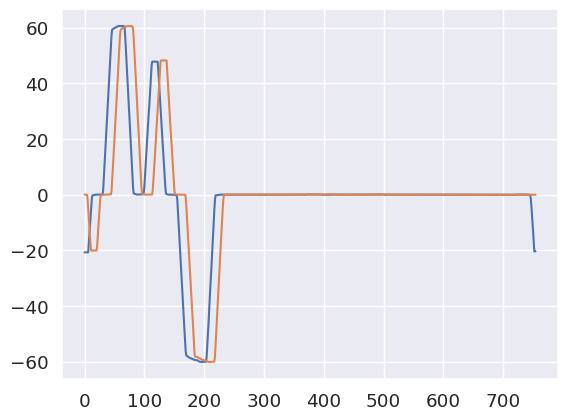

In [30]:
# Redefining for the convenience.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))

plt.plot(IMU_non_scaled[0:755:, 3])
plt.plot(IMU_non_scaled[755*100:755*101:, 3])
plt.show()

We need to **get rid of this lag** to come up with mean and median baseline windows.

First, we convert whole data to input windows and select random **three consecutive windows** to see if there is a lag.

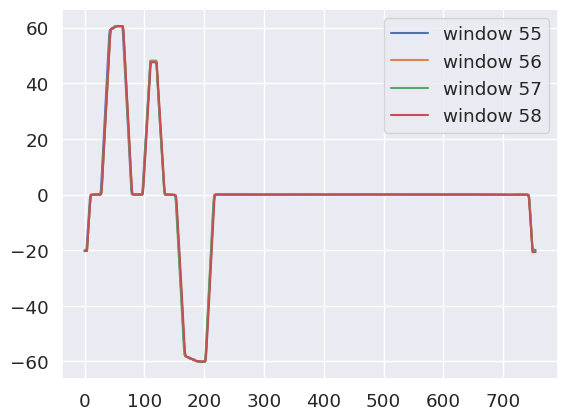

In [31]:
# Set window size.
window_size = 755
# We trim data in a way that it is exactly divided to 755.
# 1072100 data points mean 1420 windows.
IMU_cut = IMU_non_scaled[0:1072100]

# Reshape dataframe into an array of arrays with shape (1420, 755, 9).
n_windows = len(IMU_cut) // window_size

windows = np.empty((1420, 755, 9))
windows = IMU_cut[:n_windows * window_size].reshape(n_windows, window_size, -1)

# Plot windows.
plt.plot(windows[55][:, 3], label="window 55")
plt.plot(windows[56][:, 3], label="window 56")
plt.plot(windows[57][:, 3], label="window 57")
plt.plot(windows[58][:, 3], label="window 58")
plt.legend(loc="upper right")
plt.savefig('figures/consecutive_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

As we see from above plot, the windows near-perfectly match. This confirms **the lag is near-zero** between consecutive windows.

Now we plot random **three random non-consecutive windows** to spot the lag.

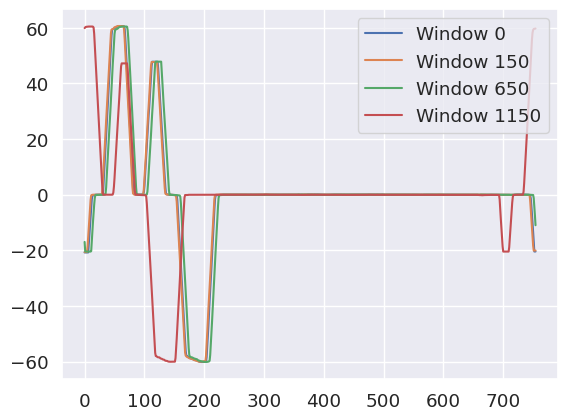

In [32]:
plt.plot(windows[0][0:755:, 3], label="Window 0")
plt.plot(windows[150][0:755, 3], label="Window 150")
plt.plot(windows[650][0:755, 3], label="Window 650")
plt.plot(windows[1150][0:755, 3], label="Window 1150")
plt.legend(loc="upper right")
plt.savefig('figures/random_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

We see that, the **lag is more obvius as the gap between the windows increases.**

Now we **detect the lag of all consecutive windows** to confirm what we claimed above.

In [33]:
# Find lag of two consecutive windows.
lag_meds = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[j][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
    # print(lag_arr)
    lag_meds.append(np.median(lag_arr))
# Print the max, min lags.
print(min(lag_meds), max(lag_meds))

-3.0 3.0


We confirmed the lags between consecutive windows are **negligible as only ranges from -3 to 3 data points**.

Now, we find the lag of all windows to the **first window**.

In [34]:
# Find lag of two consecutive windows.
lag_meds = []
lag_max = []
lag_mins = []
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        # print(lag)
        lag_arr.append(lag)
        
    lag_meds.append(np.median(lag_arr))
    lag_max.append(max(lag_arr))
    
# Print the max, min lags.
print(f"The min med: {min(lag_meds)}, the max med:{max(lag_meds)}")
print(f"The max:{max(lag_max)}")

The min med: -34.0, the max med:114.0
The max:121


This proves that the window sampling based on just **pearson correlation analysis** becomes inadequate when there are high number of near-zero values (this is our guess, need further analysis) are present within the data.

Now, **we will get rid of the lags and align all windows to the first window to come up with a stronger baseline.**

In [35]:
for j in range(n_windows - 1):
    lag_arr = []
    for i in range(windows.shape[2]):
        x = windows[0][:, i]
        y = windows[j+1][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows[j+1] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows[j+1][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows[j+1] = cut_window

Now, that all windows are aligned, **we generate the mean/median windows to be used as stronger baselines.** 

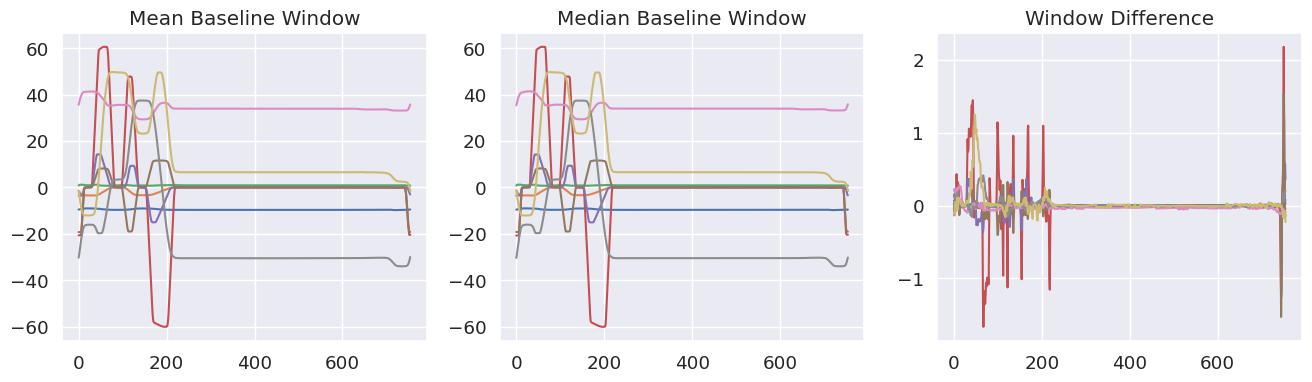

In [36]:
# Get the stronger mean/medians as baselines.
mean_window = np.mean(windows, axis=0)
median_window = np.median(windows, axis=0)

# Find difference between two windows.
diff_window = mean_window - median_window
# Visualise the baselines
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(mean_window)
ax2.plot(median_window)
ax3.plot(diff_window)
ax1.set_title("Mean Baseline Window")
ax2.set_title("Median Baseline Window")
ax3.set_title("Window Difference")
plt.savefig('figures/baseline_windows.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

Now that we have our baseline windows, we **calculate the RMSE (overall & per feature) considering the normal data only.**

In [37]:
sum_rmse_mean = 0
sum_rmse_median = 0
# Sum the RMSEs per feature.
for window in windows:
    rmse_mean = np.sqrt(np.mean((window - mean_window)**2, axis=0))
    rmse_median = np.sqrt(np.mean((window - median_window)**2, axis=0))
    sum_rmse_mean += rmse_mean
    sum_rmse_median += rmse_median
mean_per_feature = sum_rmse_mean / windows.shape[0]
median_per_feature = sum_rmse_median / windows.shape[0]
overall_mean_rmse = np.mean(mean_per_feature)
overall_median_rmse = np.mean(median_per_feature)
print(f"Mean RMSE per feature: {mean_per_feature}")
print(f"Median RMSE per feature: {median_per_feature}")
print(f"Overall mean RMSE: {overall_mean_rmse}")
print(f"Overall median RMSE: {overall_median_rmse}")

Mean RMSE per feature: [0.04278741 0.07058257 0.02718    1.27839048 0.29570638 0.50613047
 0.20503904 0.49432547 0.59824453]
Median RMSE per feature: [0.04314793 0.0714159  0.028084   1.31436817 0.30415338 0.51580648
 0.20815076 0.50062956 0.61386907]
Overall mean RMSE: 0.3909318160524488
Overall median RMSE: 0.39995836045971617


We see that **mean as a baseline beats the median**, hence we will be using **mean baseline** from now on.

Now we will **detect anomalies via the mean baseline**. First, we generate the anomalous windows and check if they align with the baseline.

Length of the anomalies 644006.


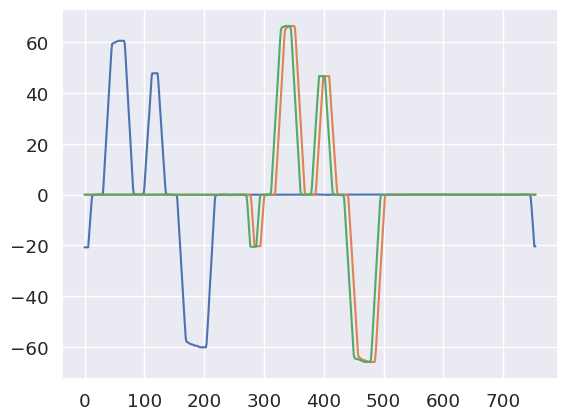

In [38]:
# Get the length of the anomalies
n_anol = len(nicla_anol)
# Print the length of the anomalies.
print(f"Length of the anomalies {n_anol}.")
# We cut in a way that it is exactly divided to window size.
anol_cut = nicla_anol[:643260]
# Reshape dataframe into an array of arrays with shape (852, 755, 9).
n_anol_windows = len(anol_cut) // window_size
windows_anol = np.empty((1420, 755, 9))
windows_anol = anol_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# Compare random windows with the baseline window.
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[1][:, 3])
plt.show()

We see that **anomalous windows are not aligned**. They neither align with the base window nor each other.

Now **we align them.**

In [39]:
for j in range(n_anol_windows):
    lag_arr = []
    for i in range(windows_anol.shape[2]):
        x = windows[0][:, i]
        y = windows_anol[j][:, i]
        correlation = signal.correlate(x-np.mean(x), y - np.mean(y), mode="full")
        lags = signal.correlation_lags(len(x), len(y), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_arr.append(lag)
    
    # Get the lag median.
    w_lag = np.median(lag_arr)
    
    # Append/Prepend the base window's points
    if int(w_lag) < 0:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][int(w_lag):]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][(-1*int(w_lag)):755]
        cut_window = np.concatenate((cut_window, points_diff), axis=0)
        windows_anol[j] = cut_window
    elif int(w_lag) == 0:
        pass
    else:
        # Get the corresponding shifted n points from the base window and append to the shifted window.
        points_diff = windows[0][0:int(w_lag)]
        # Get the part of the window that aligns with base window.
        cut_window = windows_anol[j][0:(755-int(w_lag))]
        cut_window = np.concatenate((points_diff, cut_window), axis=0)
        windows_anol[j] = cut_window

We **plot the random anomalous windows** to see if windows are aligned.

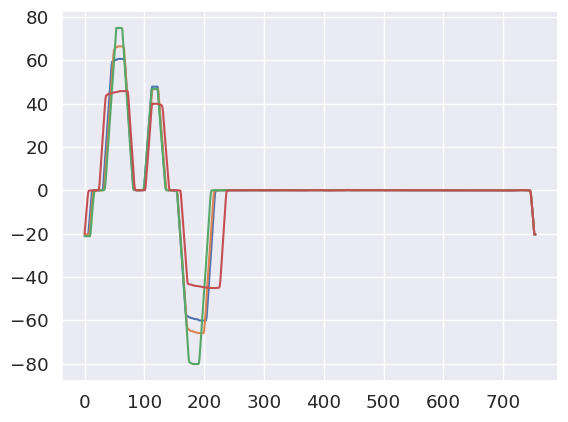

In [40]:
plt.plot(windows[0][:, 3])
plt.plot(windows_anol[0][:, 3])
plt.plot(windows_anol[150][:, 3])
plt.plot(windows_anol[-1][:, 3])
plt.show()

Due to data having anomalies, we work with **non-normalized/standardized** data until now as **anomalies affect the standardization/normalization**. There are robust methods are available but these are not utilized under the context of anomaly detection, as we want our anomalies to stay as they are here.

However, this creates an issue during the RMSE calculation (thresholding), due to data being on different scales, **one feature's noise might contribute RMSE more than the anomaly of an another feature.**

The feature scales are shown below.

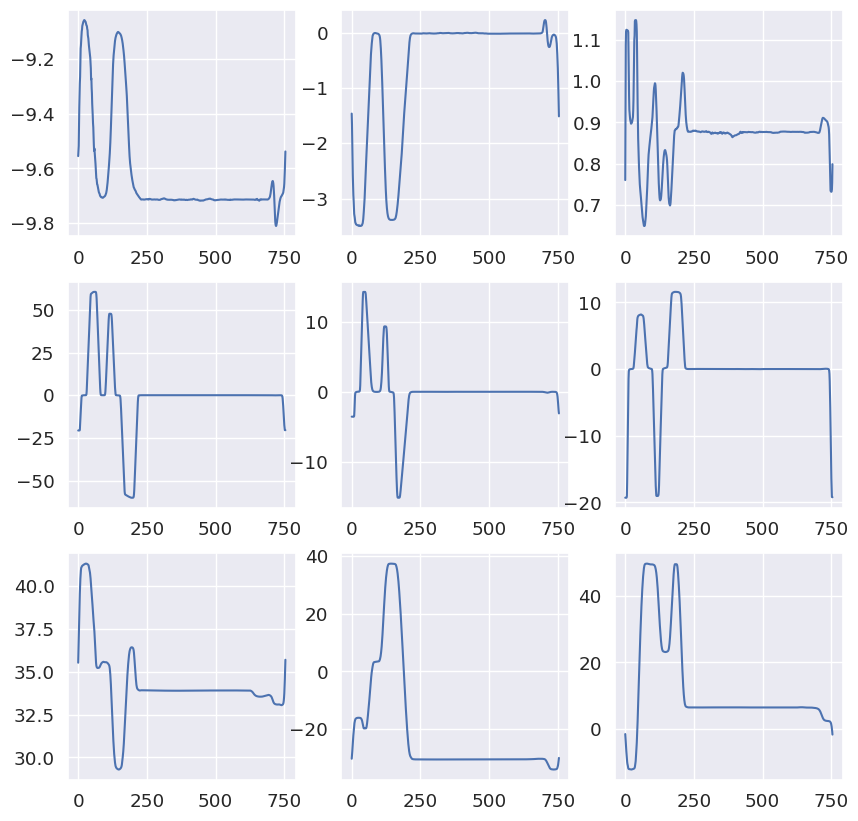

In [41]:
# Create a 3 x 3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axs array for easy indexing.
axs = axs.flatten()
for i in range(mean_window.shape[1]):
    axs[i].plot(mean_window[:, i])
plt.show()

For this reason, we **min-max normalize** the windows before calculating the RMSE.

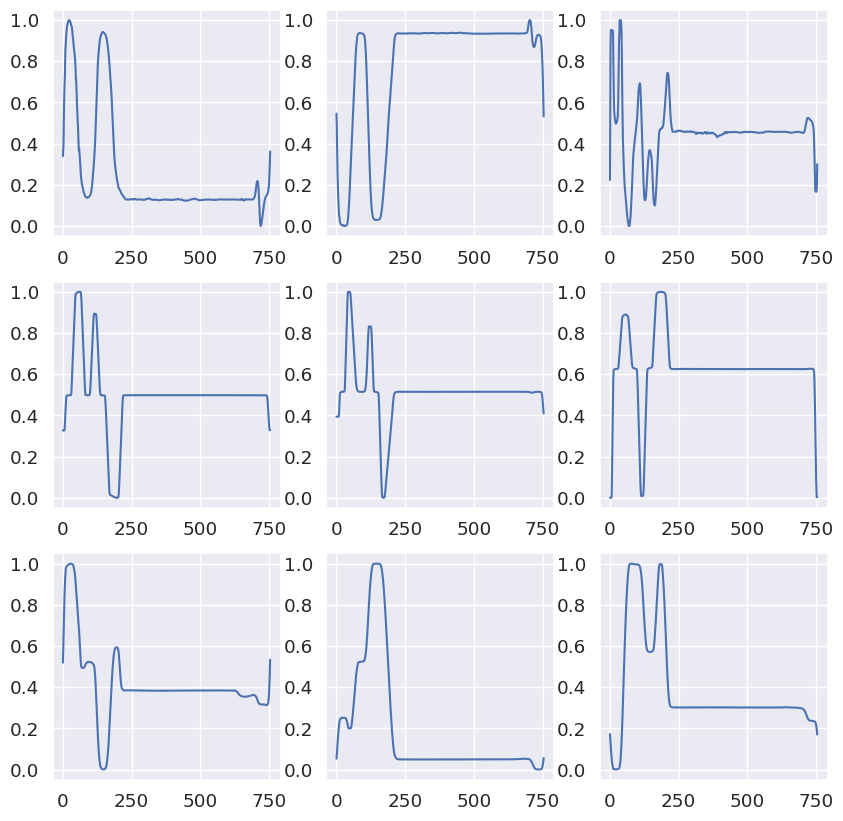

In [42]:
# Initialize a MinMaxScaler object.
scaler_mm = MinMaxScaler()

# Apply the scaler to the data.
scaler_mm.fit(mean_window)

# Scale the data.
mean_window_mm = scaler_mm.transform(mean_window)

# Create a 3 x 3 grid of subplots for scaled data.
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
# Flatten the axs array for easy indexing.
axs = axs.flatten()
for i in range(mean_window_mm.shape[1]):
    axs[i].plot(mean_window_mm[:, i])
plt.show()

Now, calculate RMSE of the windows and mean baseline window.

We utilize RMSE for the following reasons.
   1. The RMSE has the same unit as the input, hence **more interpretable**. 
   2. RMSE is more **robust against extreme anomalies and noise**. These two are common in data generated by IMU sensors.

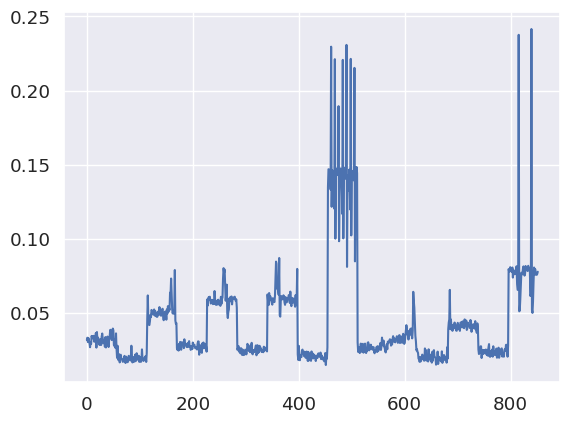

In [43]:
rmse_anols = []
# Calculate the RMSEs per feature.
for window in windows_anol:
    
    # Normalize the window via the mean window fit.
    anol_scaled = scaler_mm.transform(window)

    # 1 (anomaly) if rmse >= mean_rmse, else otherwise.
    rmse = np.mean(np.sqrt(np.mean((anol_scaled - mean_window_mm)**2, axis=0)))
    rmse_anols.append(rmse)
    
plt.plot(rmse_anols)
plt.show()

We need to set our labels correctly, as the labels we have are one per point, but we need to label our windows.

We will accept the window as **anomalous if half or more than half of the window contains anomalous points**.

Then based on a **certain threshold (found via grid search)**, we will accept the RMSE window as anomaly or not.

Grid search is a labour intensive task, thus we only provide **the final search parameters below**.

In [47]:
# Similar to windowing previously, divideable to 755.
np_labels_test_cut = np_labels_test[:643260]

# Convert into windows.
label_windows = np_labels_test_cut[:n_windows * window_size].reshape(n_anol_windows, window_size, -1)

# if sum is above 755/2 its anomaly.
label_final = []
for window in label_windows:
    if np.sum(window) > 755/2:
        label_final.append(1)
    else:
        label_final.append(0)

# Set a range of thresholds.
# We set the best one, feel free to play with these.
th = [x/10000 for x in range(380, 381, 5)]

# Label window as an anomaly, then calculate performance metrics.
baseline_results = {}
for threshold in th:
    y_pred = []
    for rmse in rmse_anols:
        if rmse >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    # Generate confusion matrix classes.
    tn, fp, fn, tp = confusion_matrix(label_final, y_pred).ravel()
    # These two are the same, this one is for heatmap.
    cf_matrix = confusion_matrix(label_final, y_pred)
    # Calculate performance metrics.
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)
    f1 = (2*prec*rec) / (prec + rec)
    
    baseline_results['Accuracy'] = acc
    baseline_results['Recall'] = rec
    baseline_results['Precision'] = prec
    baseline_results['F1'] = f1
    
    pprint(baseline_results)

{'Accuracy': 0.8744131455399061,
 'F1': 0.8664169787765292,
 'Precision': 0.9971264367816092,
 'Recall': 0.7660044150110376}


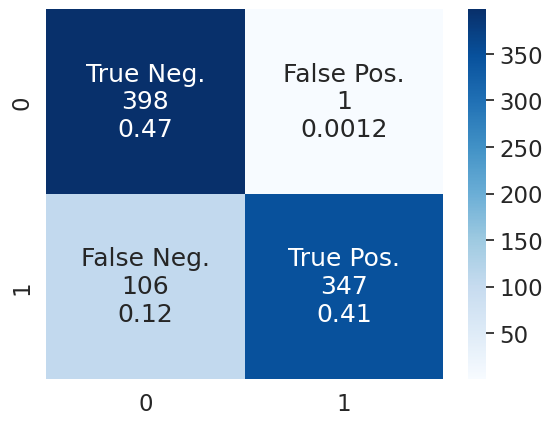

In [45]:
group_names = ["True Neg.", "False Pos.", "False Neg.", "True Pos."]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.5)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.savefig("figures/cm_baseline.pdf")
plt.show()

## 1D-CNN Based Anomaly Detection

First, we find the highest frequency **(frequency component with the largest contribution to the signal)** to be in line with **Nyquist-Shannon sampling theorem**, to see if we can reconstruct (if is ever needed).

<span style="color:red">Note: It was not needed, but I will leave this cell here anyway as might be useful to one doing frequency domain analysis. </span>.

In [46]:
# We have 9 features in total.
for i in range(9):

    # Remove the DC offset.
    IMU_no_dc =  IMU_non_scaled[:, i] - np.mean(IMU_non_scaled[:, i])
    
    # Compute the FFT of the data.
    fft_data = np.fft.fft(IMU_no_dc)

    # Compute the frequency bins corresponding to the FFT.
    # We know that the sampling rate is close to 20Hz.
    freq_bins = np.fft.fftfreq(len(IMU_no_dc), d=1/20)
        
    # Scale the frequency bins by the sampling rate
    freq_bins_hz = freq_bins * 20
    
    # Take the absolute value of the FFT data
    # and only keep the positive frequency bins.
    fft_abs = np.abs(fft_data)[:len(IMU_no_dc)//2]
    freq_bins_pos = freq_bins_hz[:len(IMU_no_dc)//2]

    # Find the max freq.
    max_freq = freq_bins_pos[np.argmax(fft_abs)]
    print(f"The max freq for feature {i} is {max_freq}")

The max freq for feature 0 is 0.5296284209054035
The max freq for feature 1 is 0.5296284209054035
The max freq for feature 2 is 4.7681476991934355
The max freq for feature 3 is 2.119259639144016
The max freq for feature 4 is 4.7681476991934355
The max freq for feature 5 is 3.1788894587160237
The max freq for feature 6 is 2.119259639144016
The max freq for feature 7 is 1.059629819572008
The max freq for feature 8 is 1.059629819572008


The below functions are provided by [TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series). We use these to facilitiate the process.

The key parameters to look at here are **the optimizer** and **the loss function**. 

In [20]:
patience = 5
batch_size = 32
sequence_stride = 1

def plot(self, model=None, plot_col='GyroY', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.plot = plot

The hyperparameters in this work are:
   1. The input window length: **755, 755x5.**
   2. The kernel size: **5, 50.**
   3. The loss function: **Adam, AdaMax.**
   4. The output window length: **1, 755.**
   5. Batch size: **32, 64.**
   6. Max pooling kernel size: **2, 3.**
   
For the convenience, we **only run the code with best parameters** here.

In [53]:
CONV_WIDTH = 5 # Kernel size.
MAX_EPOCHS = 20 # Can increase more for further analysis.
NUM_FILTERS = 64
MAX_POOL_SIZE = 3
NUM_FEATURES = 9
OUT_STEPS = 755 # This is output size.
OUT_SIZE = 1 # Gives the best result.

# Set neural network model/parameters.
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(NUM_FILTERS, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.MaxPooling1D(pool_size=MAX_POOL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_SIZE*NUM_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_SIZE, NUM_FEATURES])
])

val_performance = {}
loss = {}
val_loss = {}

model.build(input_shape=(None, 755, 9))
model.summary()
# Path to save the model.
model_path = "models/c1"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 751, 64)           2944      
                                                                 
 conv1d_1 (Conv1D)           (None, 747, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 245, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 241, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 80, 64)           0         
 1D)                                                    

We evaluate the data with **10-fold cross validation**.

In [89]:
%%time
# Set features/parameters.
num_folds = 10
tscv = TimeSeriesSplit(n_splits=num_folds)
window_size = 755

# Redefine for the convenience.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))
labels = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"]
sample = IMU_non_scaled

# Set scaler.
scaler_X = StandardScaler()

# Apply linear regression via cross validation.
# X_test is used later on to detect anomalies.
# Here we just scale the test data as well.
# Losses are calculated on train and validation data only.
for fold, (train_idx, val_idx) in enumerate(tscv.split(sample)):
    
    # Comment this for forward-chaining cross-validation.
    if fold < 9:
        continue
    
    # Split data for time series cross validation.
    X_train, X_val = sample[train_idx], sample[val_idx]

    # Scale and center the data via training only, so val data are not seen.
    scaler_X.fit(X_train)
    X_train = pd.DataFrame(scaler_X.transform(X_train), columns=labels)
    X_val = pd.DataFrame(scaler_X.transform(X_val), columns=labels)
    X_test = scaler_X.transform(nicla_anol)
    
    # Set window.
    w1 = WindowGenerator(input_width=window_size, label_width=OUT_SIZE, shift=OUT_SIZE,
                         train_df=X_train, val_df=X_val, test_df = X_test)
        
    # Verify the model input/output shape.
    print('Input shape:', w1.example[0].shape)
    print('Output shape:', model(w1.example[0]).shape)
    
    # Compile and evaluate.
    history = compile_and_fit(model, w1)
    val_performance[f"Conv_{fold+1}"] = model.evaluate(w1.val, verbose=1, return_dict=False)
    loss[f"Conv_{fold+1}"] = history.history["loss"]
    val_loss[f"Conv_{fold+1}"] = history.history["val_loss"]

Input shape: (32, 755, 9)
Output shape: (32, 1, 9)
Epoch 1/20
30444/30444 [==============================] - 304s 10ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 2/20
30444/30444 [==============================] - 302s 10ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 3/20
30444/30444 [==============================] - 302s 10ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 4/20
30444/30444 [==============================] - 302s 10ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 5/20
30444/30444 [==============================] - 302s 10ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 6/20
30444/30444 [==============================

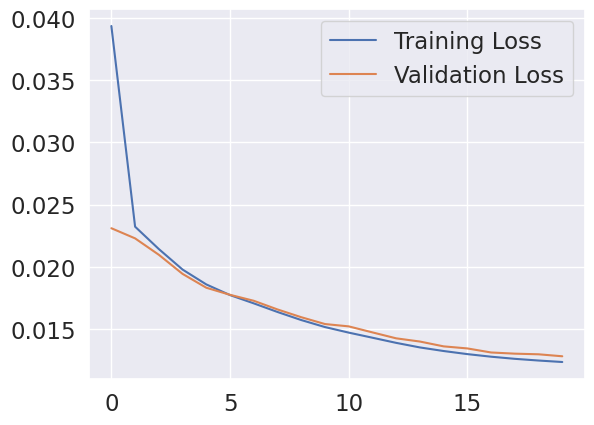

In [141]:
# Save the loss values to files.
# Just in case if kernel dies.
with open("results/training_loss.json", "w") as f:
    json.dump(loss, f)
with open("results/validation_loss.json", "w") as f1:
    json.dump(val_loss, f1)
    
# Loss values keep changing, these were the values we get during the training.
# The values on files might differ.
t = [0.03936319053173065, 0.023221876472234726, 0.021422795951366425, 
     0.019773392006754875, 0.018577663227915764, 0.017719144001603127, 
     0.017054542899131775, 0.016360972076654434, 0.015712358057498932, 
     0.015148334205150604, 0.014701241627335548, 0.014290692284703255, 
     0.013876964338123798, 0.013509090058505535, 0.01322060264647007, 
     0.012972010299563408, 0.012763460166752338, 0.01259236503392458, 
     0.012455659918487072, 0.012336998246610165]
v = [0.023097185418009758, 0.022280706092715263, 0.020961293950676918, 
     0.01942506618797779, 0.018311839550733566, 0.01774141937494278, 
     0.017261842265725136, 0.016564734280109406, 0.01594098098576069, 
     0.01539053488522768, 0.015203139744699001, 0.014719109050929546, 
     0.014241542667150497, 0.01398357655853033, 0.013594950549304485, 
     0.01342891063541174, 0.013103267177939415, 0.013008242473006248, 
     0.012957196682691574, 0.012798082083463669]
plt.plot(t, label='Training Loss')
plt.plot(v, label='Validation Loss')
plt.legend()
plt.savefig("figures/1d_cnn_loss.pdf", facecolor='white')
plt.show()

Edit the below cell according to your needs. We comment the `model.save` because **we already have our model ready**.

In [95]:
# Save the model.
# model.save(model_path)
# Load the model.
model = tf.keras.models.load_model(model_path)

We see that loss-wise 1D-CNN can beat the baseline. We do not need to align the windows as done for the baseline to implement the **sliding window approach.**

Now, we will **predict the test data** to detect the anomalies.

In [100]:
%%time
# List to hold predictions.
predictions_list = []

# -1 loop through all in original order.
for sample_inputs, sample_labels in w1.test.take(-1):
    preds = model.predict(sample_inputs, verbose=0).tolist()
    for i in range(len(preds)):
        predictions = scaler_X.inverse_transform(preds[i])
        # predictions = preds[i]
        # predictions_list.append(predictions[0].tolist())
        predictions_list.append(predictions[0])

CPU times: user 26min 6s, sys: 1min 58s, total: 28min 4s
Wall time: 22min 30s


Calculate the **RMSE per time step** and visualize.

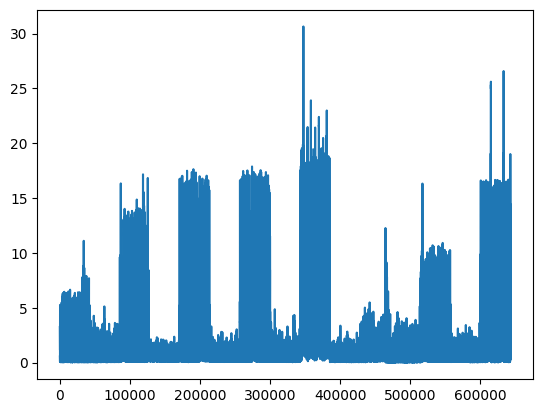

In [101]:
# Convert to numpy array for easy processing.
preds_anol = np.array(predictions_list)
# We can't predict the first 755.
target_anol = nicla_anol[755:]
# Get the RMSEs.
rmse_1dcnn = np.sqrt(np.mean((preds_anol - target_anol) ** 2, axis=1))
rmse_1dcnn
# Plot the RMSEs.
plt.plot(rmse_1dcnn)
plt.show()

When following a sliding window approach, we cannot label each point due to **high number of zeros** we have. 

Thus, we apply a **rolling sum** approach, and **create sliding windows (shifted by 1) by summing individual RMSEs.**

(643251,)


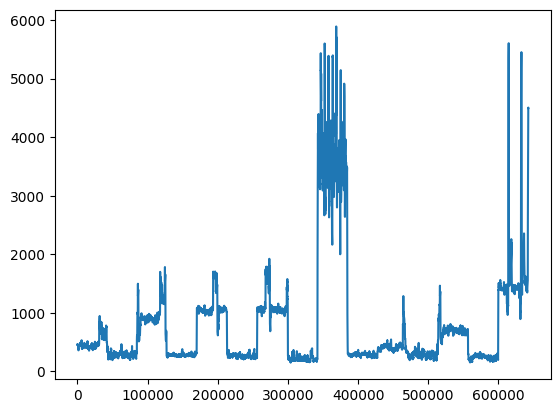

In [104]:
# Define rolling sum window size.
window_size = 755
rolling_sum_rmse = np.convolve(rmse_1dcnn, np.ones(window_size), mode='valid')
plt.plot(rolling_sum_rmse)
plt.show()

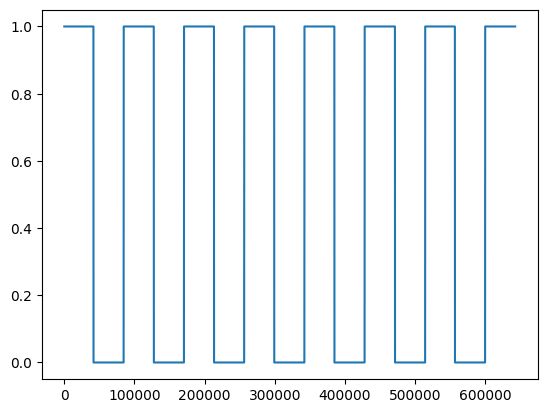

In [116]:
# Can't predict the first 755
labels_anol = np_labels_test[755:]
# Roll sum labels.
rolling_sum_labels = np.convolve(np.ravel(labels_anol), np.ones(window_size), mode='valid')
# If more than half of the window is anomalous we accept than window as an anomaly.
labels_1dcnn = []
for window in rolling_sum_labels:
    if window > 755/2:
        labels_1dcnn.append(1)
    else:
        labels_1dcnn.append(0)
        
# plot the labels
plt.plot(labels_1dcnn)
plt.show()

This approach is very similar to baseline, the main difference is that we are utilizing sliding windows.

Now we find the best **threshold via grid search**.

In [126]:
# mean_th_1dcnn = np.mean(rolling_sum_labels)
# median_th_1dcnn = np.median(rolling_sum_labels)

# Set a range of thresholds.
# We set the best one, feel free to play with these.
th_1dcnn = [x for x in range(359, 360, 1)]

# Label window as an anomaly, then calculate performance metrics.
cnn_results = {}

for threshold in th_1dcnn:
    y_pred_cnn = []
    for rmse in rolling_sum_rmse:
        if rmse >= threshold:
            y_pred_cnn.append(1)
        else:
            y_pred_cnn.append(0)
    # Generate confusion matrix classes.
    tn, fp, fn, tp = confusion_matrix(labels_1dcnn, y_pred_cnn).ravel()
    # These two are the same, this one is for heatmap.
    cf_matrix_cnn = confusion_matrix(labels_1dcnn, y_pred_cnn)
    # Calculate performance metrics.
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)
    f1 = (2*prec*rec) / (prec + rec)
    
    cnn_results['Accuracy'] = acc
    cnn_results['Recall'] = rec
    cnn_results['Precision'] = prec
    cnn_results['F1'] = f1
    
    pprint(cnn_results)

{'Accuracy': 0.9717913079749789,
 'F1': 0.9735891838643962,
 'Precision': 0.9682837821778161,
 'Recall': 0.97895304436506}


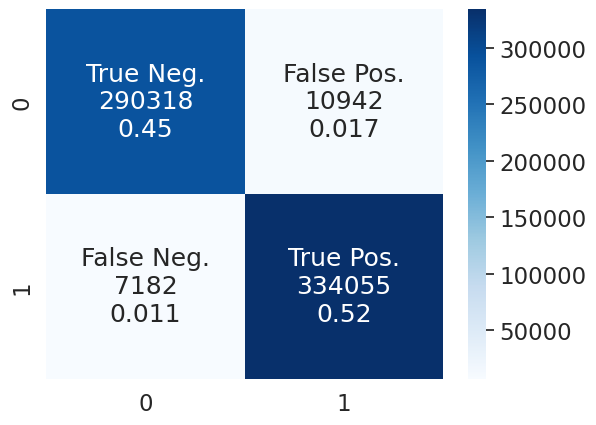

In [142]:
# Generate the confusion matrix.
group_counts_cnn = ["{0:0.0f}".format(value) for value in
                cf_matrix_cnn.flatten()]

group_percentages_cnn = ["{0:.2}".format(value) for value in
                     cf_matrix_cnn.flatten()/np.sum(cf_matrix_cnn)]

labels_cnn = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts_cnn,group_percentages_cnn)]
labels_cnn = np.asarray(labels_cnn).reshape(2,2)
sns.set(font_scale=1.5)
sns.heatmap(cf_matrix, annot=labels_cnn, fmt="", cmap='Blues')
plt.savefig("figures/cm_cnn.pdf")
plt.show()

## XGBOOST

Among boosting algorithms, we test the **performance of XGBoost** via 10-fold forward chaining cross validation.

Data are normalized via **z-score normalization**.

In [28]:
%%time
# Set features/parameters.
num_folds = 10
tscv = TimeSeriesSplit(n_splits=num_folds)
window_size = 755
# Redefine for the convenience.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))

# Remove the final "window_size" points, as they will be predicted only.
sample = IMU_non_scaled[:-window_size]
# Shift the validation set by window_size
sample2 = IMU_non_scaled[window_size:]
# Set scalers.
scaler_X = StandardScaler()
scaler_y = StandardScaler()
# To hold RMSE scores.
rmse_scores_xgboost = []

# Apply linear regression via cross validation.
for fold, (train_idx, val_idx) in enumerate(tscv.split(sample)):
    
    # The RMSE appears to be near-same in all folds.
    # Accelerate the process, skip the first 9 folds.
    # Uncomment to include all folds. 
    if fold < 9:
        continue
    
    # Split data for time series cross validation.
    X_train, X_val = sample[train_idx], sample[val_idx]
    y_train, y_val = sample2[train_idx], sample2[val_idx]    
    
    # Scale and center the data via training only, so test data are not seen.
    scaler_X.fit(X_train)
    scaler_y.fit(y_train)
    X_train = scaler_X.transform(X_train)
    X_val = scaler_X.transform(X_val)
    y_train = scaler_y.transform(y_train)
    y_val = scaler_y.transform(y_val)
    
    # Fit and train the model.
    regr_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, 
                                max_depth=5, random_state=42).fit(X_train, y_train)
    # Predict.
    y_xgb = regr_xgb.predict(X_val)
     
    # Calculate RMSE.
    rmse_xgb = mean_squared_error(y_val, y_xgb, squared=False)
    
    # Append to a list.
    rmse_scores_xgboost.append(rmse_xgb)
    
print(f"RMSE Xgboost {np.mean(rmse_scores_xgboost)}")

RMSE Xgboost 0.12998864282069356
CPU times: user 14min 28s, sys: 486 ms, total: 14min 29s
Wall time: 1min 6s


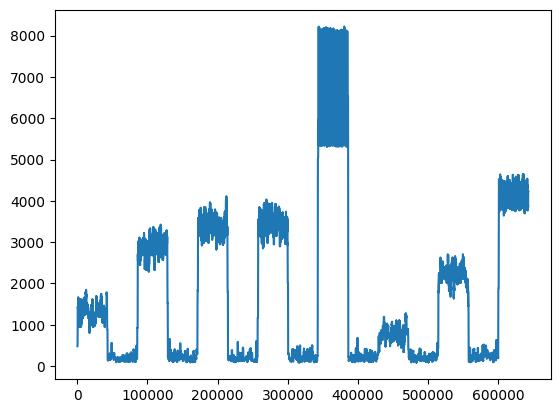

{'Accuracy': 0.9781500873685585,
 'F1': 0.9796665928848265,
 'Precision': 0.9695076381233267,
 'Recall': 0.990040702706496}


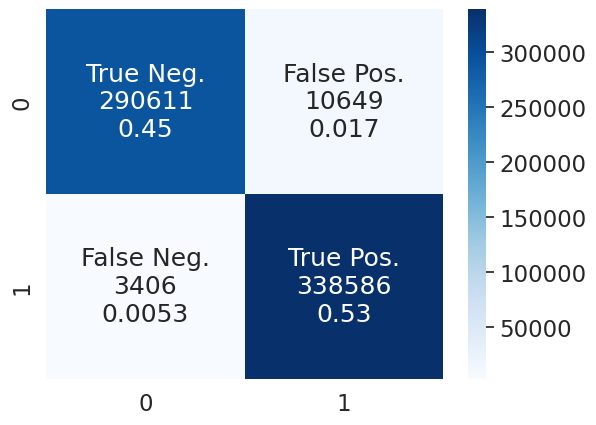

In [55]:
# Define window size again.
window_size = 755

# Get the last 755 points of normal data.
d1 = IMU_non_scaled[-window_size:]
# Remove the last 755 of test data, as they can't be predicted.
d2 = nicla_anol[:-window_size]
# Merge d1 and d2, the data to be used for prediction.
pred_input = np.concatenate((d1, d2))

# Normalize data with training parameters.
pred_input = scaler_y.transform(pred_input)

# Pred via XGB.
pred_output = regr_xgb.predict(pred_input)

# Inverse transform.
pred_output = scaler_y.inverse_transform(pred_output)

# Get the RMSEs.
rmse_xgb = np.sqrt(np.mean((pred_output - nicla_anol) ** 2, axis=1))

# We roll sum due to high number of zeros.
# We do the same approach for CNN as well.
rmse_xgb = np.convolve(rmse_xgb, np.ones(window_size), mode='valid')

# Plot the RMSEs.
plt.plot(rmse_xgb)
plt.show()

# Roll sum labels.
rolling_sum_labels_xgb = np.convolve(np.ravel(np_labels_test), np.ones(window_size), mode='valid')
# If more than half of the window is anomalous we accept than window as an anomaly.
labels_xgb = []
for window in rolling_sum_labels_xgb:
    if window > 755/2:
        labels_xgb.append(1)
    else:
        labels_xgb.append(0)

# Threshold grid search.
# We set the best.
th_xgb = [x for x in range(504, 505, 1)]

# Label window as an anomaly, then calculate performance metrics.
results_xgb = {}

for threshold in th_xgb:
    y_pred_xgb = []
    for rmse in rmse_xgb:
        if rmse >= threshold:
            y_pred_xgb.append(1)
        else:
            y_pred_xgb.append(0)
    # Generate confusion matrix classes.
    tn, fp, fn, tp = confusion_matrix(labels_xgb, y_pred_xgb).ravel()
    # These two are the same, this one is for heatmap.
    cf_matrix_xgb = confusion_matrix(labels_xgb, y_pred_xgb)
    # Calculate performance metrics.
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)
    f1 = (2*prec*rec) / (prec + rec)
    
    results_xgb['Accuracy'] = acc
    results_xgb['Recall'] = rec
    results_xgb['Precision'] = prec
    results_xgb['F1'] = f1
    
    pprint(results_xgb)
    
group_names = ["True Neg.", "False Pos.", "False Neg.", "True Pos."]
# Generate the confusion matrix.
group_counts_xgb = ["{0:0.0f}".format(value) for value in
                cf_matrix_xgb.flatten()]

group_percentages_xgb = ["{0:.2}".format(value) for value in
                     cf_matrix_xgb.flatten()/np.sum(cf_matrix_xgb)]

labels_xgb = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts_xgb,group_percentages_xgb)]
labels_xgb = np.asarray(labels_xgb).reshape(2,2)
sns.set(font_scale=1.5)
sns.heatmap(cf_matrix_xgb, annot=labels_xgb, fmt="", cmap='Blues')
plt.savefig("figures/cm_xgb.pdf")
plt.show()

## LSTM
We also test via LSTM. 

The training takes much longer time. Even 1 LSTM layer overfits. Our attempts to get rid of the overfitting failed even though we introduced dropout layer and L1 regularization.

In [33]:
%%time

patience = 5
batch_size = 256 # Adjust if LSTM or CNN
sequence_stride = 1

def plot(self, model=None, plot_col='GyroY', max_subplots=1):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

def compile_and_fit(model, window, patience=patience):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adamax(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                 [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                  axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
             data=data,
             targets=None,
             sequence_length=self.total_window_size,
             sequence_stride=sequence_stride,
             shuffle=False,
             batch_size=batch_size,)

    ds = ds.map(self.split_window)

    return ds

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.plot = plot

MAX_EPOCHS = 20
NUM_FILTERS = 32
NUM_FEATURES = 9
OUT_SIZE = 1

val_performance_lstm = {}
loss_lstm = {}
val_loss_lstm = {}

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(NUM_FILTERS, return_sequences=False, input_shape=(755, 9), 
                         kernel_regularizer=regularizers.l1(0.001)),
    tf.keras.layers.Dense(NUM_FILTERS, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_FEATURES),
    tf.keras.layers.Reshape([1, NUM_FEATURES], input_shape=(NUM_FEATURES,))
])

model.summary()

# Path to save the model.
model_path = "models/lstm"

# Set features/parameters.
num_folds = 10
tscv = TimeSeriesSplit(n_splits=num_folds)
window_size = 755

# Redefine for convenience purposes.
IMU_non_scaled = np.hstack((np_acc, np_gyro, np_mag))
labels = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"]
sample = IMU_non_scaled

# Set scaler.
scaler_X = StandardScaler()

# Apply linear regression via cross validation.
# X_test is used later on to detect anomalies.
# Here we just scale the test data as well.
# Losses are calculated on train and validation data only.
for fold, (train_idx, val_idx) in enumerate(tscv.split(sample)):
    
    # Comment this to run forward-chaining cross validation.
    # We leave like this for quick testing.
    if fold < 9:
        continue
    
    # Split data for time series cross validation.
    X_train, X_val = sample[train_idx], sample[val_idx]

    # Scale and center the data via training only, so val data are not seen.
    scaler_X.fit(X_train)
    X_train = pd.DataFrame(scaler_X.transform(X_train), columns=labels)
    X_val = pd.DataFrame(scaler_X.transform(X_val), columns=labels)
    X_test = scaler_X.transform(nicla_anol)
    
    # Set window.
    w1_lstm = WindowGenerator(input_width=window_size, label_width=OUT_SIZE, shift=OUT_SIZE,
                         train_df=X_train, val_df=X_val, test_df = X_test)
        
    # Verify the model input/output shape.
    print('Input shape:', w1_lstm.example[0].shape)
    print('Output shape:', model(w1_lstm.example[0]).shape)
    
    # Compile and evaluate.
    history = compile_and_fit(model, w1_lstm)
    val_performance_lstm[f"Conv_{fold+1}"] = model.evaluate(w1_lstm.val, verbose=1, return_dict=False)
    loss_lstm[f"Conv_{fold+1}"] = history.history["loss"]
    val_loss_lstm[f"Conv_{fold+1}"] = history.history["val_loss"]
    
# Save the loss values to files.
# Just in case if kernel dies.
with open("results/training_loss_lstm.json", "w") as f:
    json.dump(loss_lstm, f)
with open("results/validation_loss_lstm.json", "w") as f1:
    json.dump(val_loss_lstm, f1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 32)                5376      
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 9)                 297       
                                                                 
 reshape_7 (Reshape)         (None, 1, 9)              0         
                                                                 
Total params: 6,729
Trainable params: 6,729
Non-trainable params: 0
_________________________________________________________________
Input indices: [  0   1   2   3   4   5   6   7   8 

Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242

Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242

Epoch 8/20
3806/3806 [==============================] - 204s 54ms/step - loss: 0.0663 - root_mean_squared_error: 0.2540 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1157
Epoch 9/20
3806/3806 [==============================] - 201s 53ms/step - loss: 0.0664 - root_mean_squared_error: 0.2544 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1200
Epoch 10/20
3806/3806 [==============================] - 204s 54ms/step - loss: 0.0661 - root_mean_squared_error: 0.2539 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1137
Epoch 11/20
3806/3806 [==============================] - 203s 53ms/step - loss: 0.0658 - root_mean_squared_error: 0.2535 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1163
Epoch 12/20
3806/3806 [==============================] - 203s 53ms/step - loss: 0.0653 - root_mean_squared_error: 0.2527 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1149
Epoch 13/20
3806/3806 [==============================] - 204s 54ms/step - loss: 0.0667 - root_mean_squared_error

You can **load the model** if you would like to skip the training. Comment/Uncomment accordingly.

In [34]:
# Save the model.
# model.save(model_path)
# Load the model.
model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: models/lstm/assets


INFO:tensorflow:Assets written to: models/lstm/assets


{'Conv_10': [0.01307043805718422, 0.10903239250183105]}


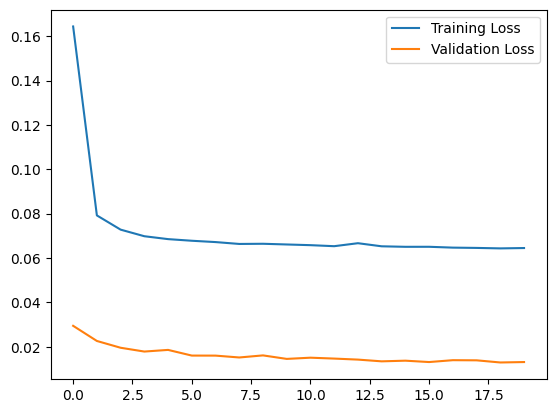

In [37]:
# Print the performance.
pprint(val_performance_lstm)
# Generate the loss graph.
t = loss_lstm['Conv_10']
v = val_loss_lstm['Conv_10']
plt.plot(t, label='Training Loss')
plt.plot(v, label='Validation Loss')
plt.legend()
plt.savefig("figures/lstm_loss_4.pdf", facecolor='white')
plt.show()

This model obviously **overfits**, the loss is much smaller than its counterparts.

We detect the anomalies in the same way.

In [38]:
%%time
# List to hold predictions.
predictions_list_lstm = []

# -1 loop through all in original order.
for sample_inputs, sample_labels in w1_lstm.test.take(-1):
    preds = model.predict(sample_inputs, verbose=0).tolist()
    for i in range(len(preds)):
        predictions = scaler_X.inverse_transform(preds[i])
        # predictions = preds[i]
        # predictions_list.append(predictions[0].tolist())
        predictions_list_lstm.append(predictions[0])

CPU times: user 13min 26s, sys: 1min 8s, total: 14min 35s
Wall time: 9min 56s


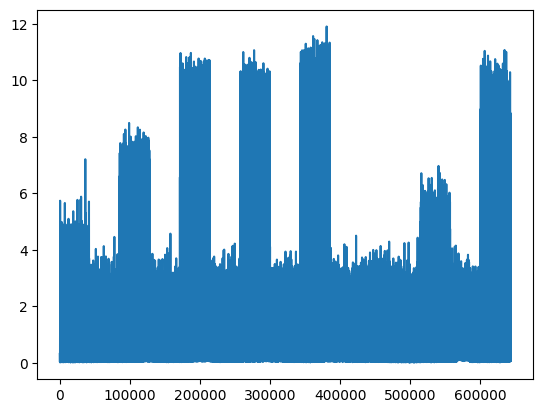

In [39]:
# Convert to numpy array for easy processing.
preds_anol = np.array(predictions_list_lstm)
# We can't predict the first 755.
target_anol = nicla_anol[755:]
# Get the RMSEs.
rmse_lstm = np.sqrt(np.mean((preds_anol - target_anol) ** 2, axis=1))
rmse_lstm
# Plot the RMSEs.
plt.plot(rmse_lstm)
plt.show()

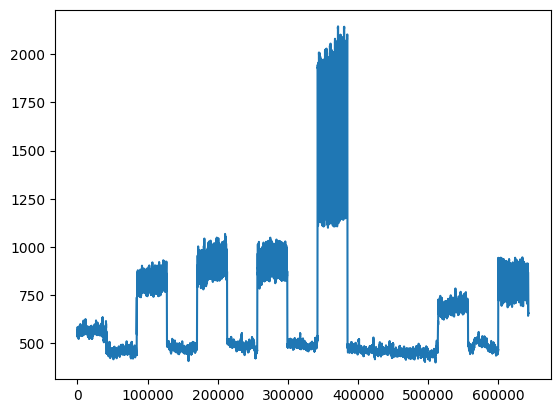

In [40]:
# Define rolling sum window size.
window_size = 755
rolling_sum_rmse_lstm = np.convolve(rmse_lstm, np.ones(window_size), mode='valid')
plt.plot(rolling_sum_rmse_lstm)
plt.show()

We can see from the above graph, that **overfitting causes decrease in detection performance** (5% joint velocity decrease) is barely visible.

In [52]:
# Can't predict the first 755
labels_anol = np_labels_test[755:]
# Roll sum labels.
rolling_sum_labels = np.convolve(np.ravel(labels_anol), np.ones(window_size), mode='valid')
# If more than half of the window is anomalous we accept than window as an anomaly.
labels_lstm = []
for window in rolling_sum_labels:
    if window > 755/2:
        labels_lstm.append(1)
    else:
        labels_lstm.append(0)

# Set a range of thresholds.
# We set the best one, feel free to play with these.
th_lstm = [x for x in range(530, 531, 1)]

# Label window as an anomaly, then calculate performance metrics.
lstm_results = {}

for threshold in th_lstm:
    y_pred_lstm = []
    for rmse in rolling_sum_rmse_lstm:
        if rmse >= threshold:
            y_pred_lstm.append(1)
        else:
            y_pred_lstm.append(0)
    # Generate confusion matrix classes.
    tn, fp, fn, tp = confusion_matrix(labels_lstm, y_pred_lstm).ravel()
    # These two are the same, this one is for heatmap.
    cf_matrix_lstm = confusion_matrix(labels_lstm, y_pred_lstm)
    # Calculate performance metrics.
    acc = (tp + tn) / (tp + tn + fp + fn)
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)
    f1 = (2*prec*rec) / (prec + rec)
    
    lstm_results['Accuracy'] = acc
    lstm_results['Recall'] = rec
    lstm_results['Precision'] = prec
    lstm_results['F1'] = f1

    pprint(lstm_results)

{'Accuracy': 0.9250237744300751,
 'F1': 0.924841873367637,
 'Precision': 0.9889224403997264,
 'Recall': 0.8685605605488268}
